In [1]:
# %pip install pandas numpy tensorflow matplotlib tensorflow-metal

In [2]:
import os
import ssl
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.nn import softmax, log_softmax
from tqdm.notebook import tqdm

## Testing whether tensorflow will use GPU or not

In [3]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


## Setting up the Configs

In [4]:
os.listdir("./")

['klimb_llm_optimization_challenge',
 '.DS_Store',
 'ML_Challenge.code-workspace',
 'Challenge.ipynb',
 '.venv',
 'teacher_model.pkl',
 'tmp']

In [5]:
# Path of train and test data
train_dir = "./klimb_llm_optimization_challenge/seg_train/"
test_dir = "./klimb_llm_optimization_challenge/seg_test/"

In [6]:
# Data configs
batch_size = 32
img_height = 150
img_width = 150
seed = 123
num_classes = 6

In [7]:
ssl._create_default_https_context = ssl._create_unverified_context

## Loading the Train and Test Set from the directory

In [8]:
validation_split = 0.2

In [9]:
lr = 0.001

In [10]:
# Load train data
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
train_dir,
  validation_split=validation_split,
  subset="both",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.


2024-02-09 01:01:48.456726: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-09 01:01:48.456744: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-09 01:01:48.456752: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-09 01:01:48.456786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-09 01:01:48.457034: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.


In [12]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [13]:
def preprocess_batch(images, labels):
    # Preprocess images using preprocess_input
    images = preprocess_input(images)
    return images, labels

In [14]:
preprocess_train_ds = train_ds.map(preprocess_batch)

In [15]:
preprocess_test_ds = test_ds.map(preprocess_batch)

In [16]:
preprocess_val_ds = val_ds.map(preprocess_batch)

In [17]:
# Training the MASTER Model - using Transfer Learning
# Here we are using ImageNet pre-trained model weights
base_model = keras.applications.ResNet152(
		weights='imagenet',  # Load weights pre-trained on ImageNet.
		input_shape=(img_height, img_width, 3),
		include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False


In [18]:
inputs = keras.Input(shape=(img_height, img_width, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

In [19]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [20]:
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [21]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0)

In [22]:
checkpoint_filepath = './tmp/checkpoint'

In [23]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

In [24]:
model.summary()
model.compile(
		optimizer=keras.optimizers.legacy.Adam(learning_rate=lr),
		loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
		metrics=[keras.metrics.SparseCategoricalAccuracy()], 
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 5, 5, 2048)        58370944  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 58383238 (222.71 MB)
Trainable params: 12294 (48.02 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________


In [25]:
# train_epochs = 20
# history = model.fit(preprocess_train_ds, epochs=train_epochs, callbacks=[scheduler_callback, checkpoint_callback, earlystopping_callback], verbose=1, validation_data=preprocess_val_ds)

In [26]:
# for layer in model.layers:
#     layer.trainable = False

In [27]:
# model.save("./teacher_model.pkl")

In [28]:
model.load_weights("./teacher_model.pkl/")

2024-02-09 01:01:52.929176: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./teacher_model.pkl/: FAILED_PRECONDITION: teacher_model.pkl; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [29]:
val_labels = model.predict(val_ds)

2024-02-09 01:01:54.279684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 38s 413ms/step


In [30]:
test_labels = model.predict(test_ds)

94/94 [==============================] - 37s 397ms/step


In [31]:
test_reults = model.evaluate(test_ds)

94/94 [==============================] - 39s 391ms/step - loss: 0.5907 - sparse_categorical_accuracy: 0.7997


In [32]:
train_labels = model.predict(train_ds)

351/351 [==============================] - 153s 436ms/step


In [54]:
def create_student_model(input_shape, num_classes):
  model = keras.models.Sequential()
  model.add(layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, strides=(1,1)))
  model.add(layers.MaxPooling2D((2, 2), padding='valid', strides=(1,1)))
  model.add(layers.Conv2D(64, kernel_size= (5, 5), activation='relu', strides=(1,1)))
  model.add(layers.MaxPooling2D((4,4), padding='valid', strides=(1,1)))
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(num_classes))
  return model

In [55]:
student_model = create_student_model((img_height, img_width, 3), 6)

In [56]:
student_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_3 (Conv2D  (None, 152, 152, 32)      896       
 Transpose)                                                      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 151, 151, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 147, 147, 64)      51264     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 144, 144, 64)      0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_4  (None, 64)                0         
  (GlobalAveragePooling2D)                            

In [57]:
T = 7.0
alpha = 0.3
num_epochs = 15

In [58]:
def train_student_model(teacher_model, student_model, train_ds, val_ds, num_epochs=50, learning_rate=lr):
  optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate)
  criterian_distillation = keras.losses.KLDivergence()
  criterian = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  accuracy_fn = keras.metrics.SparseCategoricalAccuracy()
  train_epoch_loss = np.array([])
  train_epoch_accuracy = np.array([])

  val_epoch_loss = np.array([])
  val_epoch_accuracy = np.array([])
  for epoch in range(num_epochs):
    train_batch_loss = np.array([])
    train_batch_accuracy = np.array([])

    val_batch_loss = np.array([])
    val_batch_accuracy = np.array([])

    for batch_inputs, batch_labels in tqdm(train_ds):

      with tf.GradientTape() as tape:

        student_logits = student_model(batch_inputs, training=True)
        teacher_logits = teacher_model(batch_inputs, training=False)


        distillation_loss = criterian_distillation(log_softmax(teacher_logits / T, axis=-1), softmax(student_logits / T, axis=-1))

        hard_target_loss = criterian(batch_labels, student_logits)

        loss = alpha * hard_target_loss + (1.0 - alpha) * T ** 2 * distillation_loss

        accuracy_fn.update_state(y_true=batch_labels, y_pred=student_logits)
        train_batch_loss = np.append(train_batch_loss, loss.numpy())
        train_batch_accuracy = np.append(train_batch_accuracy, accuracy_fn.result().numpy())

      grads = tape.gradient(loss, student_model.trainable_variables)
      optimizer.apply_gradients(zip(grads, student_model.trainable_variables))

    train_epoch_accuracy = np.append(train_epoch_accuracy, train_batch_accuracy.mean())
    train_epoch_loss = np.append( train_epoch_loss, train_batch_loss.mean())

    for batch_inputs, batch_labels in tqdm(val_ds):

      student_logits = student_model(batch_inputs, training=False)
      teacher_logits = teacher_model(batch_inputs, training=False)

      distillation_loss = criterian_distillation(log_softmax(teacher_logits / T, axis=-1), softmax(student_logits / T, axis=-1))

      hard_target_loss = criterian(batch_labels, student_logits)

      loss = alpha * hard_target_loss + (1.0 - alpha) * T ** 2 * distillation_loss

      accuracy_fn.update_state(y_true=batch_labels, y_pred=student_logits)
      val_batch_loss = np.append(val_batch_loss, loss.numpy())
      val_batch_accuracy = np.append(val_batch_accuracy, accuracy_fn.result().numpy())

    val_epoch_accuracy = np.append(val_epoch_accuracy, val_batch_accuracy.mean())
    val_epoch_loss = np.append(val_epoch_loss, val_batch_loss.mean())
    min_val_epoch_loss = min(val_epoch_loss)
    
    if min_val_epoch_loss == val_epoch_loss[epoch]:
      print("Saving checkpoint")
      student_model.save_weights("./student_model/checkpoint/")
    
    else:
      print("Validation loss has increased hence not saving checkpoint")


    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_epoch_loss[epoch]}')
    print(f"Epoch [{epoch + 1}/{num_epochs}],  Train Accuracy: {train_epoch_accuracy[epoch]}")
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_epoch_loss[epoch]}')
    print(f"Epoch [{epoch + 1}/{num_epochs}],  Validation Accuracy: {val_epoch_accuracy[epoch]}")
  return student_model, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy

In [59]:
student_model, train_loss, train_accuracy, val_loss, val_accuracy = train_student_model(model, student_model, preprocess_train_ds, preprocess_val_ds, num_epochs, lr)

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Saving checkpoint
Epoch [1/15], Train Loss: 0.6281450319069403
Epoch [1/15],  Train Accuracy: 0.46611725201464105
Epoch [1/15], Validation Loss: 0.27210166051306506
Epoch [1/15],  Validation Accuracy: 0.568781899457628


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Saving checkpoint
Epoch [2/15], Train Loss: 0.2608698692671594
Epoch [2/15],  Train Accuracy: 0.6021511014710125
Epoch [2/15], Validation Loss: 0.2426182274621996
Epoch [2/15],  Validation Accuracy: 0.6262805577028882


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Saving checkpoint
Epoch [3/15], Train Loss: 0.23684818930181004
Epoch [3/15],  Train Accuracy: 0.6433461636219948
Epoch [3/15], Validation Loss: 0.20630823634564877
Epoch [3/15],  Validation Accuracy: 0.6574571979316798


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Validation loss has increased hence not saving checkpoint
Epoch [4/15], Train Loss: 0.2157093257009134
Epoch [4/15],  Train Accuracy: 0.6691873211127061
Epoch [4/15], Validation Loss: 0.21251927172257143
Epoch [4/15],  Validation Accuracy: 0.6789951338009401


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Validation loss has increased hence not saving checkpoint
Epoch [5/15], Train Loss: 0.21405470403086427
Epoch [5/15],  Train Accuracy: 0.686135262505621
Epoch [5/15], Validation Loss: 0.22817758902568708
Epoch [5/15],  Validation Accuracy: 0.6909506259994074


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Saving checkpoint
Epoch [6/15], Train Loss: 0.20443601367140768
Epoch [6/15],  Train Accuracy: 0.695523583821082
Epoch [6/15], Validation Loss: 0.1873821628025987
Epoch [6/15],  Validation Accuracy: 0.7006486498496749


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Saving checkpoint
Epoch [7/15], Train Loss: 0.19765021325091692
Epoch [7/15],  Train Accuracy: 0.7058517061747037
Epoch [7/15], Validation Loss: 0.17803616313771767
Epoch [7/15],  Validation Accuracy: 0.7103222019293092


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Validation loss has increased hence not saving checkpoint
Epoch [8/15], Train Loss: 0.191572881555795
Epoch [8/15],  Train Accuracy: 0.7149045037747788
Epoch [8/15], Validation Loss: 0.17883622053671966
Epoch [8/15],  Validation Accuracy: 0.7184305841272528


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Validation loss has increased hence not saving checkpoint
Epoch [9/15], Train Loss: 0.18668069369942375
Epoch [9/15],  Train Accuracy: 0.7221217277722481
Epoch [9/15], Validation Loss: 0.18652029530229894
Epoch [9/15],  Validation Accuracy: 0.7251135571436449


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Validation loss has increased hence not saving checkpoint
Epoch [10/15], Train Loss: 0.1795806909813161
Epoch [10/15],  Train Accuracy: 0.7286388204987572
Epoch [10/15], Validation Loss: 0.18889242122796449
Epoch [10/15],  Validation Accuracy: 0.7310115241191604


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Saving checkpoint
Epoch [11/15], Train Loss: 0.17631927240862805
Epoch [11/15],  Train Accuracy: 0.7335941881535739
Epoch [11/15], Validation Loss: 0.17554659362543712
Epoch [11/15],  Validation Accuracy: 0.7361338626254689


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Saving checkpoint
Epoch [12/15], Train Loss: 0.1747839253427636
Epoch [12/15],  Train Accuracy: 0.738684838314002
Epoch [12/15], Validation Loss: 0.17361309760334817
Epoch [12/15],  Validation Accuracy: 0.7409396300261671


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Saving checkpoint
Epoch [13/15], Train Loss: 0.1702711629307168
Epoch [13/15],  Train Accuracy: 0.7432975718098828
Epoch [13/15], Validation Loss: 0.17024040954526176
Epoch [13/15],  Validation Accuracy: 0.7451205714182421


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Saving checkpoint
Epoch [14/15], Train Loss: 0.16575277311212658
Epoch [14/15],  Train Accuracy: 0.7473923733771017
Epoch [14/15], Validation Loss: 0.16108575238930908
Epoch [14/15],  Validation Accuracy: 0.7494508759541945


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

Saving checkpoint
Epoch [15/15], Train Loss: 0.16436281963715865
Epoch [15/15],  Train Accuracy: 0.7515055353824909
Epoch [15/15], Validation Loss: 0.15170756621624937
Epoch [15/15],  Validation Accuracy: 0.7532578435811129


In [60]:
student_model.save("./student_model.pkl")

INFO:tensorflow:Assets written to: ./student_model.pkl/assets


INFO:tensorflow:Assets written to: ./student_model.pkl/assets


In [63]:
student_model.load_weights("./student_model.pkl")

2024-02-09 10:46:00.164406: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./student_model.pkl: FAILED_PRECONDITION: student_model.pkl; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [64]:
acc_fn = keras.metrics.SparseCategoricalAccuracy()
test_acc = np.array([])
for batch_input, batch_label in preprocess_test_ds:
    student_test_logits = student_model(batch_input, training=False)
    acc_fn.update_state(batch_label, student_test_logits)
    batch_acc = acc_fn.result().numpy()
    test_acc = np.append(test_acc, batch_acc)


In [65]:
test_acc.mean()

0.8063186927044645

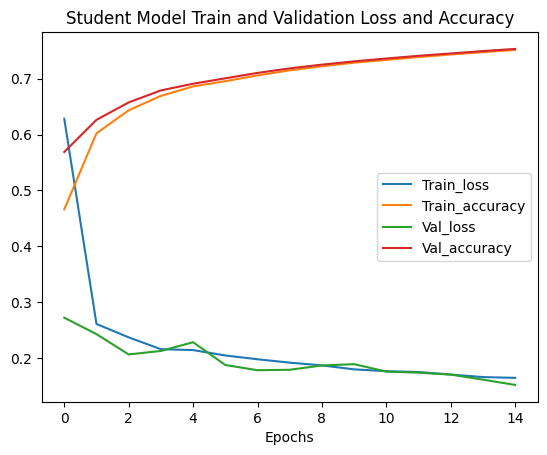

In [72]:
plt.plot(train_loss)
plt.plot(train_accuracy)
plt.plot(val_loss)
plt.plot(val_accuracy)
plt.xlabel("Epochs")
plt.legend(["Train_loss", "Train_accuracy", "Val_loss", "Val_accuracy"])
plt.title("Student Model Train and Validation Loss and Accuracy")
plt.show()